In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
import numpy as np
import math
import random

In [4]:
def show_state(env, episode,step, info=""):
    plt.figure(99999,figsize=[8,6])
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("episode: {} step: {} ".format(episode,step))
    #plt.title("%s | Step: %d %s" % (env._spec.id,step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

In [5]:
import gym

In [6]:
use_cuda = torch.cuda.is_available()
device=torch.device("cuda:4" if use_cuda else "cpu")

In [7]:
###### PARAMS ######
learning_rate = 0.01
num_episodes = 1000
#gamma=0.99
gamma=0.85
egreedy = 0.9
egreedy_final = 0.02
egreedy_decay = 500

report_interval=10

In [8]:
env = gym.make('CartPole-v1')

In [9]:
#env = gym.wrappers.Monitor(env, '../mp4/sandbox10',video_callable=lambda episode_id: True,force=True)
#env = gym.wrappers.Monitor(env, '../mp4/cartpole-5',video_callable=lambda episode_id: episode_id%10==0)

In [10]:
number_of_inputs=env.observation_space.shape[0]
number_of_outputs=env.action_space.n

In [11]:

egreedy_prev = egreedy
egreedy_prev_final = egreedy_final
egreedy_prev_decay = 0.999

In [12]:
def calculate_epsilon(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * \
              math.exp(-1. * steps_done / egreedy_decay )
    return epsilon

In [13]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(number_of_inputs,number_of_outputs)
        
    def forward(self, x):
        output = self.linear1(x)
        return output

samplenn=NeuralNetwork().to(device)

state = env.reset()

state=torch.Tensor(state).to(device)
state

samplenn(state)

sample_loss_function= nn.MSELoss()

action=env.action_space.sample()
new_state, reward, done, info = env.step(action)
#state=torch.Tensor(state).to(device)
new_state=torch.Tensor(new_state).to(device)
reward=torch.Tensor([reward]).to(device)

new_state_values=samplenn(new_state).detach()
max_new_state_values=torch.max(new_state_values)
target_value=reward + gamma*max_new_state_values

target_value

predicted_value=samplenn(state)[action].view((-1))

predicted_value

sample_loss_function(predicted_value,target_value)

ttest=torch.Tensor([2,4,6])

i=torch.argmax(ttest)

i

ttest[i].item()

In [14]:
class QNet_Agent():
    def __init__(self):
        self.nn = NeuralNetwork().to(device)
        self.loss_function = nn.MSELoss()
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
        
    def select_action(self,state,epsilon):
        
        random_for_egreedy=torch.rand(1).item()
        
        if random_for_egreedy>epsilon:
            self.nn.eval()
            with torch.no_grad():
                state=torch.Tensor(state).to(device)
                action_predicted_rewards_from_nn=self.nn(state)
                action=torch.argmax(action_predicted_rewards_from_nn).item()
        else:
            action=env.action_space.sample()
                
                
        return action
    
    def optimize(self, state, action, new_state, reward, done):
        
        state=torch.Tensor(state).to(device)
        new_state=torch.Tensor(new_state).to(device)
        reward=torch.Tensor([reward]).to(device)
        
        
        if done:
            target_value=reward
        else:
            self.nn.eval()
            new_state_values=self.nn(new_state).detach()
            max_new_state_values=torch.max(new_state_values)
            target_value=reward + gamma*max_new_state_values
        
        self.nn.train()
        #the view call needed to make it a tensor
        predicted_value=self.nn(state)[action].view(-1)
        
        loss=self.loss_function(predicted_value,target_value)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        

In [15]:
qnet_agent=QNet_Agent()

In [16]:
seed_value=23
env.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)

In [17]:
%%time

num_episodes=1000

steps_total=np.full([num_episodes],-999,dtype=np.int32)

frames_total=0

start_time = time.time()

for i_episode in range(num_episodes):
    
    state = env.reset()
    #for step in range(100):
    step=0
    while True:
        
        step+=1
        
        epsilon=calculate_epsilon(frames_total)
        
        #action=env.action_space.sample()
        action=qnet_agent.select_action(state,epsilon)
        
        new_state, reward, done, info = env.step(action)
        
        qnet_agent.optimize(state,
                            action,
                            new_state,
                            reward,
                            done)
        
        state=new_state
        
        if done:
            steps_total[i_episode]=step
            print("Episode {} finished after: {}".format(i_episode,step))
            break
        

Episode 0 finished after: 17
Episode 1 finished after: 29
Episode 2 finished after: 10
Episode 3 finished after: 54
Episode 4 finished after: 17
Episode 5 finished after: 25
Episode 6 finished after: 28
Episode 7 finished after: 10
Episode 8 finished after: 13
Episode 9 finished after: 19
Episode 10 finished after: 14
Episode 11 finished after: 14
Episode 12 finished after: 20
Episode 13 finished after: 14
Episode 14 finished after: 10
Episode 15 finished after: 14
Episode 16 finished after: 41
Episode 17 finished after: 25
Episode 18 finished after: 12
Episode 19 finished after: 18
Episode 20 finished after: 14
Episode 21 finished after: 36
Episode 22 finished after: 21
Episode 23 finished after: 13
Episode 24 finished after: 21
Episode 25 finished after: 58
Episode 26 finished after: 13
Episode 27 finished after: 11
Episode 28 finished after: 14
Episode 29 finished after: 31
Episode 30 finished after: 32
Episode 31 finished after: 13
Episode 32 finished after: 15
Episode 33 finished 

Episode 274 finished after: 18
Episode 275 finished after: 31
Episode 276 finished after: 11
Episode 277 finished after: 15
Episode 278 finished after: 16
Episode 279 finished after: 23
Episode 280 finished after: 28
Episode 281 finished after: 11
Episode 282 finished after: 16
Episode 283 finished after: 28
Episode 284 finished after: 17
Episode 285 finished after: 11
Episode 286 finished after: 51
Episode 287 finished after: 45
Episode 288 finished after: 25
Episode 289 finished after: 11
Episode 290 finished after: 11
Episode 291 finished after: 16
Episode 292 finished after: 38
Episode 293 finished after: 14
Episode 294 finished after: 20
Episode 295 finished after: 10
Episode 296 finished after: 13
Episode 297 finished after: 33
Episode 298 finished after: 10
Episode 299 finished after: 32
Episode 300 finished after: 44
Episode 301 finished after: 62
Episode 302 finished after: 20
Episode 303 finished after: 17
Episode 304 finished after: 24
Episode 305 finished after: 21
Episode 

Episode 540 finished after: 65
Episode 541 finished after: 18
Episode 542 finished after: 51
Episode 543 finished after: 13
Episode 544 finished after: 33
Episode 545 finished after: 12
Episode 546 finished after: 12
Episode 547 finished after: 9
Episode 548 finished after: 13
Episode 549 finished after: 11
Episode 550 finished after: 12
Episode 551 finished after: 12
Episode 552 finished after: 13
Episode 553 finished after: 27
Episode 554 finished after: 14
Episode 555 finished after: 22
Episode 556 finished after: 20
Episode 557 finished after: 36
Episode 558 finished after: 14
Episode 559 finished after: 43
Episode 560 finished after: 12
Episode 561 finished after: 16
Episode 562 finished after: 40
Episode 563 finished after: 10
Episode 564 finished after: 42
Episode 565 finished after: 29
Episode 566 finished after: 27
Episode 567 finished after: 23
Episode 568 finished after: 27
Episode 569 finished after: 16
Episode 570 finished after: 17
Episode 571 finished after: 13
Episode 5

Episode 806 finished after: 23
Episode 807 finished after: 12
Episode 808 finished after: 24
Episode 809 finished after: 27
Episode 810 finished after: 24
Episode 811 finished after: 14
Episode 812 finished after: 13
Episode 813 finished after: 16
Episode 814 finished after: 40
Episode 815 finished after: 9
Episode 816 finished after: 12
Episode 817 finished after: 17
Episode 818 finished after: 12
Episode 819 finished after: 14
Episode 820 finished after: 15
Episode 821 finished after: 17
Episode 822 finished after: 12
Episode 823 finished after: 18
Episode 824 finished after: 15
Episode 825 finished after: 15
Episode 826 finished after: 28
Episode 827 finished after: 15
Episode 828 finished after: 19
Episode 829 finished after: 12
Episode 830 finished after: 15
Episode 831 finished after: 11
Episode 832 finished after: 13
Episode 833 finished after: 13
Episode 834 finished after: 19
Episode 835 finished after: 27
Episode 836 finished after: 10
Episode 837 finished after: 20
Episode 8

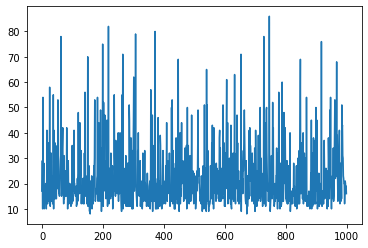

In [18]:
plt.plot(steps_total)
plt.show()

In [19]:
print("Average number of steps: {}". format(np.average(steps_total)))

Average number of steps: 22.311


In [20]:
print("Average number of steps=reward: {}". format(np.average(steps_total)))
print("Average number of steps=reward in last 100 episodes: {}". format(np.average(steps_total[-100:])))



Average number of steps=reward: 22.311
Average number of steps=reward in last 100 episodes: 23.19


plt.figure(1,figsize=[12,5])
plt.title("Rewards")
plt.bar(torch.arange(len(rewards_total)), rewards_total,alpha=0.6, color='green')
#plt.plot(rewards_total)
plt.show()

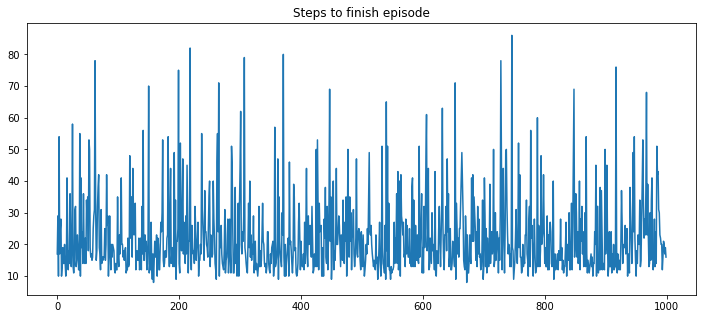

In [21]:
plt.figure(2,figsize=[12,5])
plt.title("Steps to finish episode")
plt.plot(steps_total)
plt.show()